In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
import seaborn as sns
import pandas as pd

import time

In [41]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data=pd.read_csv(url,sep=';')
data=data[data['total sulfur dioxide']<200]

cols2zscore=data.keys()
cols2zscore=cols2zscore.drop('quality')
data[cols2zscore]=data[cols2zscore].apply(stats.zscore)
data.values

array([[-0.52835005,  0.96065692, -1.39182311, ..., -0.58021615,
        -0.9593068 ,  5.        ],
       [-0.29867328,  1.96661447, -1.39182311, ...,  0.12783672,
        -0.58334117,  5.        ],
       [-0.29867328,  1.2959761 , -1.18598036, ..., -0.0491765 ,
        -0.58334117,  5.        ],
       ...,
       [-1.15996117, -0.10118717, -0.72283417, ...,  0.54086757,
         0.54455574,  6.        ],
       [-1.38963794,  0.653281  , -0.77429485, ...,  0.30484994,
        -0.20737553,  5.        ],
       [-1.33221875, -1.21891778,  1.02682924, ...,  0.00982791,
         0.54455574,  6.        ]])

In [37]:
def createTrainAndTest_dataset(threshold=5):
    
    data['boolquality']=0
    
    data['boolquality']=(data['quality']>threshold).astype(int)
    
    output={}
    
    dataTen=torch.tensor(data[cols2zscore].values).float()
    labelten=torch.tensor(data['boolquality'].values).float()
    labelten=labelten[:,None]
    
    output['data']=dataTen
    output['label']=labelten
    
    train_data,test_data,train_label,test_label=train_test_split(dataTen,labelten,train_size=.9)
    
    train_dataset=TensorDataset(train_data,train_label)
    test_dataset=TensorDataset(test_data,test_label)
    
    train_loader=DataLoader(train_dataset,batch_size=16,shuffle=True,drop_last=True)
    test_loader=DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])
    
    output['train_loader']=train_loader
    output['test_loader']=test_loader
    
    return output

In [47]:
output=createTrainAndTest_dataset(6)
qualityRange=output['train_loader'].dataset.tensors[1].detach()
print(f'low-rated wines: {torch.sum(qualityRange==0)}')
print(f'high-rated wines: {torch.sum(qualityRange==1)}')

low-rated wines: 1252
high-rated wines: 185


In [58]:
def createModel():
    
    class ANNmodule(nn.Module):
        
        def __init__(self):
            super().__init__()
            
            self.input=nn.Linear(11,32)
            
            self.hidden_1=nn.Linear(32,64)
            self.hidden_2=nn.Linear(64,32)
            
            self.output=nn.Linear(32,1)
        
        def forward(self,x):
            x=F.leaky_relu(self.input(x))
            
            x=F.leaky_relu(self.hidden_1(x))
            x=F.leaky_relu(self.hidden_2(x))
            
            return self.output(x)
        
    ann=ANNmodule()
    
    lossfun=nn.BCEWithLogitsLoss()
    
    optimizer=torch.optim.Adam(ann.parameters(),lr=0.001)#,weight_decay=0.01)
    
    return ann,lossfun,optimizer

In [65]:
#ann module test with little data
ann=createModel()[0]
arr=np.random.randn(2,11)
arr=torch.tensor(arr).float()
print(ann(arr)>0)
# print(arr)

tensor([[False],
        [False]])


In [6]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

def trainModelwithGpu(dataset,Numepoch=100):
    
    train_loader=dataset['train_loader']
    test_loader=dataset['test_loader']
    
    #train and test accuracies over each epoch
    trainAcc=[]
    testAcc=[]
    losses=torch.zeros(Numepoch)
    
    #the time spended training process
    processTime=time.process_time()
       
    #create new ann model
    ANN,lossfun,optimizer=createModel()
    
    ANN.to(device)
    
    for epoch in range(Numepoch):
        # time
        startTime=time.process_time()
        
        #accuracy and loss over one epoch
        batchAcc=[]
        batchLoss=[]
        
        ANN.train()
        
        for dat,lab in train_loader:
            
            dat=dat.to(device)
            lab=lab.to(device)
            
            yHat=ANN(dat)
            loss=lossfun(yHat,lab)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchLoss.append(loss.item())
            
            yHat=yHat.cpu()
            lab=lab.cpu()
            
            match=((yHat>0)==lab).float()
            batchAcc.append(100*torch.mean(match).item())
            
            
        
        trainAcc.append(np.mean(batchAcc))
        losses[epoch]=np.mean(batchLoss)

        ANN.eval()
        dat,lab=next(iter(test_loader))
        
        dat=dat.to(device)
        lab=lab.to(device)
            
        with torch.no_grad():
            yHat=ANN(dat)
        
        yHat=yHat.cpu()
        lab=lab.cpu()
            
        testAcc.append(100*torch.mean( ((yHat>0)==lab).float()))
        
        completedTime=time.process_time()-startTime
        
#         print(f'{epoch+1}-th trainAcc:{trainAcc[epoch]},----testAcc{testAcc[epoch]},----lossValue:{losses[epoch]},---CompTime {completedTime:.2f}-sec')
        
    processTime=time.process_time()-processTime  

    return ANN,trainAcc,testAcc,losses,processTime

cuda:0


In [56]:
dataset=createTrainAndTest_dataset(5.5)
ANN,trainAcc,testAcc,losses,processTime=trainModelwithGpu(dataset,1000)

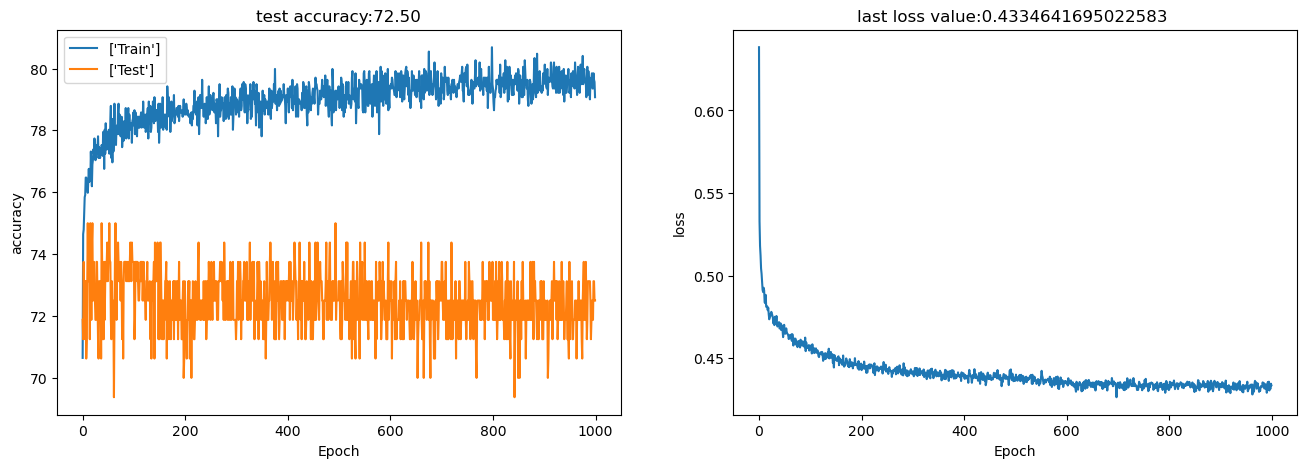

In [57]:
fig,ax=plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainAcc,label=['Train'])
ax[0].plot(testAcc,label=['Test'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('accuracy')
ax[0].set_title(f'test accuracy:{testAcc[-1]:.2f}')
ax[0].legend()

ax[1].plot(losses)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('loss')
ax[1].set_title(f'last loss value:{losses[-1]} ')
plt.show()

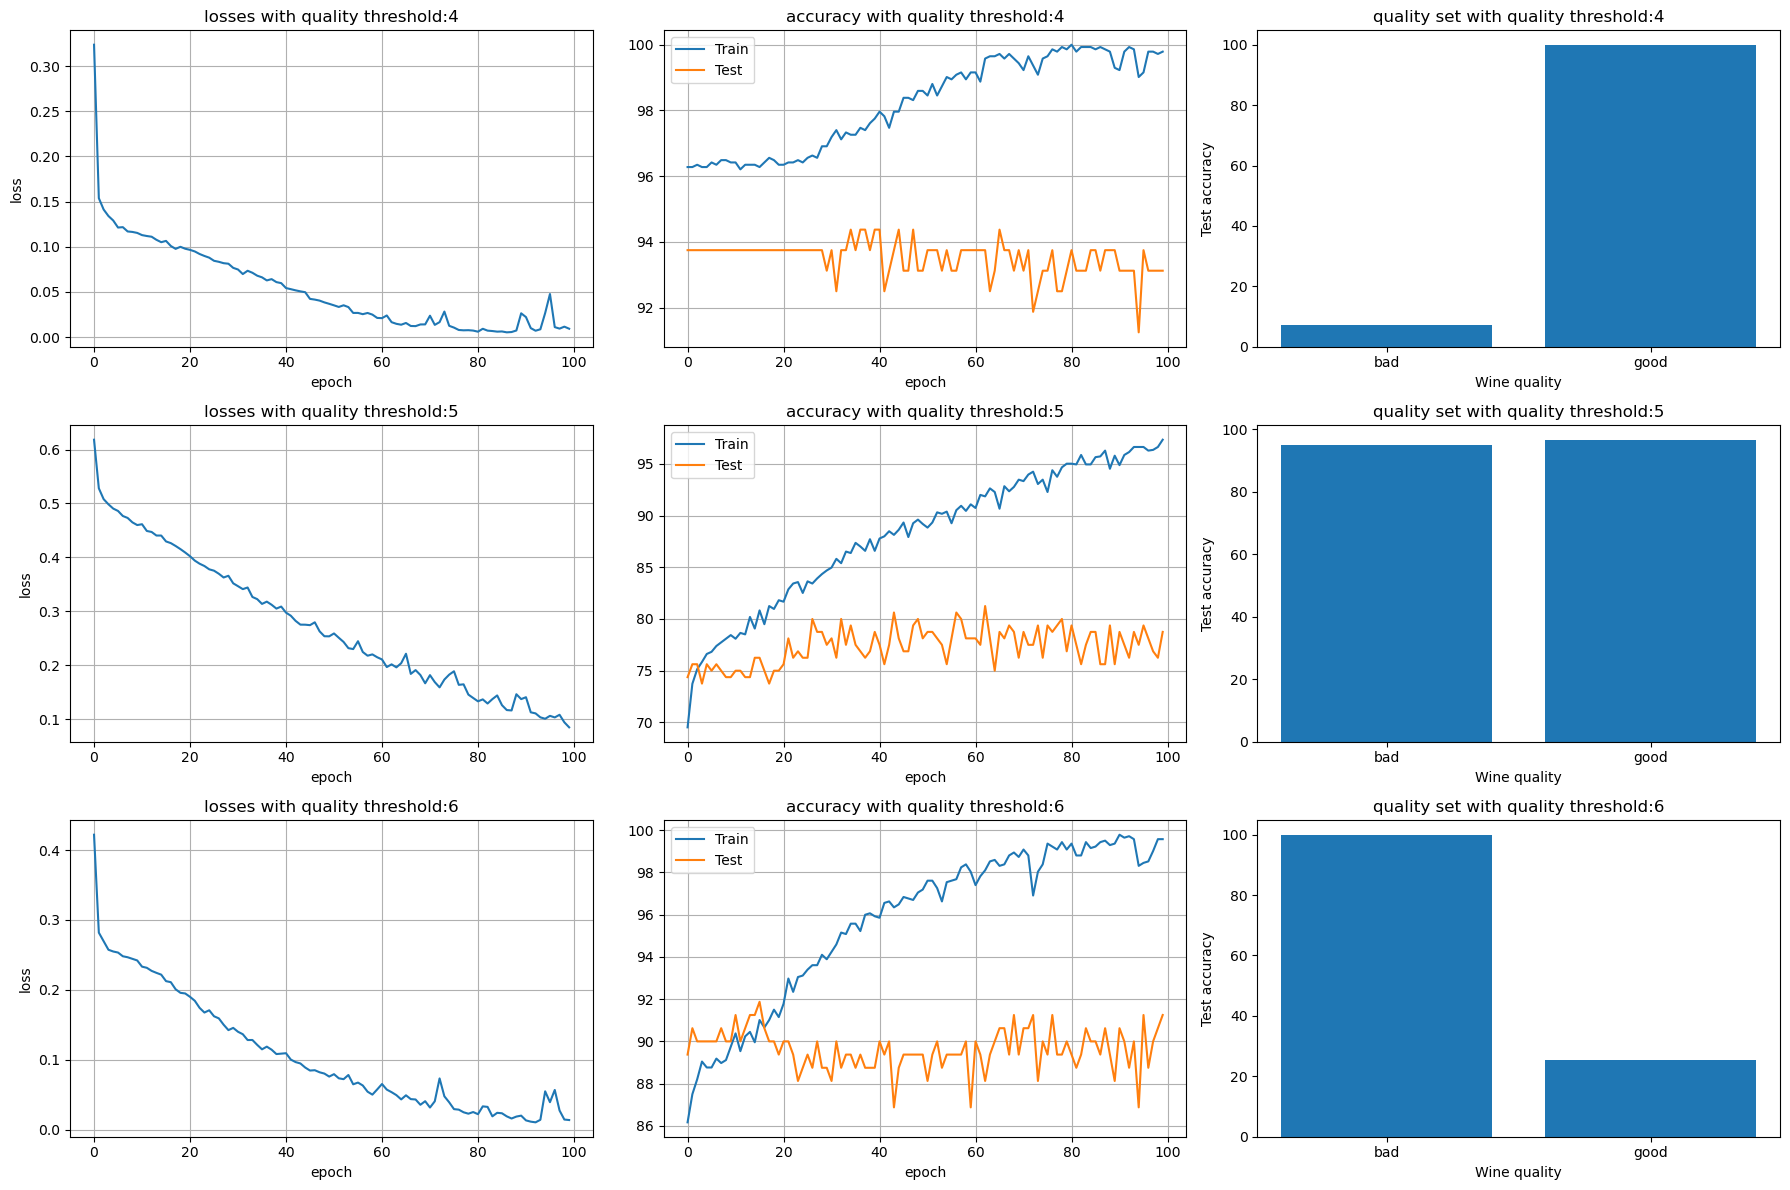

In [48]:
fig,ax=plt.subplots(3,3,figsize=(18,12))
qualityThresh=[4,5,6]

for Qual in range(len(qualityThresh)):

    output=createTrainAndTest_dataset(qualityThresh[Qual])
    
    ANN,trainAcc,testAcc,losses,processTime=trainModelwithGpu(output,100)
    
    dataTr=dataset['data'].to(device)
    labelTr=dataset['label']
    
    prediction=ANN(dataTr)
    
    dataTr=dataTr.cpu()
    prediction=prediction.cpu()
    
    accuracy=((prediction>0)==labelTr).float()
    
    QualitySet=[100*torch.mean(accuracy[label==0]),\
                100*torch.mean(accuracy[label==1])]
    
    ax[Qual,0].plot(losses)
    ax[Qual,0].set_title(f'losses with quality threshold:{qualityThresh[Qual]}')
    ax[Qual,0].set_xlabel('epoch')
    ax[Qual,0].set_ylabel('loss')
    ax[Qual,0].grid()
    
    ax[Qual,1].plot(trainAcc,label='Train')
    ax[Qual,1].plot(testAcc,label='Test')
    ax[Qual,1].legend()
    ax[Qual,1].set_title(f'accuracy with quality threshold:{qualityThresh[Qual]}')
    ax[Qual,1].set_xlabel('epoch')
    ax[Qual,1].set_ylim([0,100])
    ax[Qual,1].grid()

    ax[Qual,2].bar(['bad','good'],QualitySet)
    ax[Qual,2].set_xlabel('Wine quality')
    ax[Qual,2].set_ylabel('Test accuracy') 
    ax[Qual,2].set_ylim([0,100])
    ax[Qual,2].set_title(f'quality set with quality threshold:{qualityThresh[Qual]}')
plt.tight_layout()
plt.show()